# IF867 - Introdução à Aprendizagem Profunda
## 1ª atividade prática - 2025.1

Discente(s):
- Ana Sofia Lima (asosl)
- João Vitor Mergulhão (jvlm2)

## Instruções e requisitos
- Objetivo: Implementar e treinar um Multi-Layer Perceptron e uma Rede Neural Convolucional, inteiramente em PyTorch.
- Observação: A atividade pode ser feita em dupla.

## Tarefa

- Rede Neural Convolucional (CNN) (50% da nota):
  - Implementação: Proponha e construa sua própria arquitetura de CNN.
  - Implemente funções para o treinamento e avaliação do modelo.
  - Métricas e Análise:
    - Registre o tempo de treinamento de cada configuração.
    - Gere e apresente a matriz de confusão para os resultados da classificação.
    - Plote gráficos da função de loss e da acurácia ao longo das épocas de treinamento.
  - Experimentação:
    - Aplique e avalie técnicas de regularização (ex: Dropout, Batch Normalization).
    - Implemente e analise o Grad-CAM para visualização e interpretabilidade.
    - Explore outras técnicas relevantes para otimização ou análise de CNNs.
  - Relatório: Documente no notebook os experimentos realizados, as configurações utilizadas e os resultados obtidos, analisando o impacto de cada alteração.

O dataset escolhido foi o CIFAR10:
- Imagens 32x32
- composto por 10 classes

## Imports

In [ ]:
!pip install torchcam
!pip install opencv-python

In [1]:
import torch
from  torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchcam.methods import GradCAM

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset setup

In [2]:
# Define as transformações com data augmentation para o treinamento
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define as transformações sem data augmentation
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

train_val_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_val_dataset_plain = CIFAR10(root='./data', train=True, download=True, transform=val_test_transform)

# Extrai os rótulos
targets = np.array(train_val_dataset_plain.targets)

# Cria o validador estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Gera os índices
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(train_val_dataset, train_idx)     # com augmentation
    val_dataset = Subset(train_val_dataset_plain, val_idx)       # sem augmentation

# Dataset de teste também sem augmentation
test_dataset = CIFAR10(root='./data', train=False, download=False, transform=val_test_transform)

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32,
                                          shuffle = True, num_workers=2)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32,
                                          shuffle = False, num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32,
                                          shuffle = False, num_workers=2)

## Data visualization

In [15]:
def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

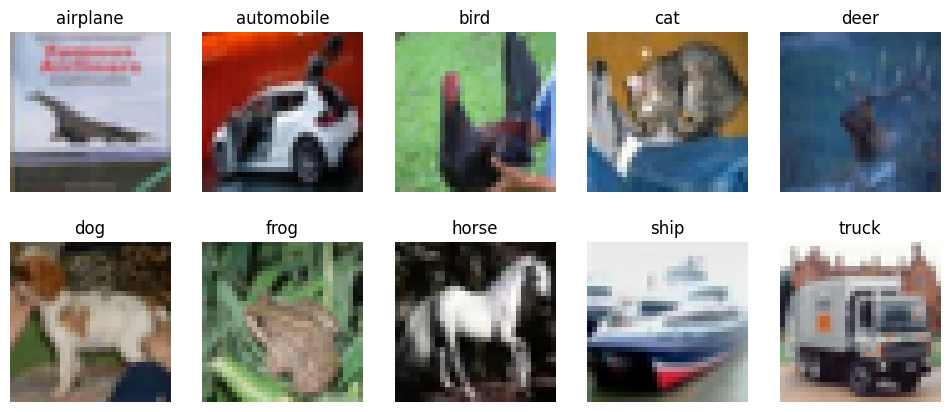

In [17]:
classes = test_dataset.classes

# Encontrar uma imagem de cada classe
images_per_class = {}
# Itera sobre o dataset até encontrar uma imagem para cada uma das 10 classes
for img, label in test_dataset:
    class_name = classes[label]
    if class_name not in images_per_class:
        images_per_class[class_name] = img
    # Para de procurar quando já tiver uma imagem de cada classe
    if len(images_per_class) == len(classes):
        break

# Criar uma figura para exibir as imagens
fig = plt.figure(figsize=(12, 5))

# Exibe uma imagem para cada classe
for i, class_name in enumerate(classes):
    ax = fig.add_subplot(2, 5, i + 1) # Cria uma grade 2x5 de subplots
    ax.set_title(class_name)
    imshow(images_per_class[class_name])

plt.show()

## Evaluation Functions

In [55]:
def evaluate(net, loader, loss_function):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
    net.train()
    return val_loss / len(loader)

In [72]:
def plotTrainVal(train_loss, val_loss, train_acc, val_acc):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Gráfico de Loss
    axes[0].plot(train_loss, label='Treinamento')
    axes[0].plot(val_loss, label='Validação')
    axes[0].set_title('Loss por Época')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Gráfico de Acurácia
    axes[1].plot(train_acc, label='Treinamento')
    axes[1].plot(val_acc, label='Validação')
    axes[1].set_title('Acurácia por Época')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Acurácia')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [56]:
def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [57]:
def makePredictions(net, test_loader):
  net.eval()
  predictions = []
  labels = []
  for images, label in test_loader:
    images = images.to(device)
    label = label.to(device)

    output = net(images)
    _, predicted = torch.max(output,1)

    predictions.extend(predicted.cpu().numpy())
    labels.extend(label.cpu().numpy())

  return labels, predictions

## CNN Definition

A arquitetura base para o projeto é uma versão simplificada da VGG. Com todos os kernels das convoluções com dimensão 3x3 e paddings = 1.

Também há a possibilidade de adicionar dropout nas camadas lineares e batch normalization entre as convoluções.

Detalhamento:

- Bloco 1:
    - Conv2d (3 -> 64)
    - ReLU
    - MaxPool2d(2, 2)
- Bloco 2:
    - Conv2d(64 → 128)
    - ReLU
    - Conv2d(128 → 128)
    - ReLU
    - MaxPool2d(2, 2)
- Bloco 3:
    - Conv2d(128 → 256)
    - ReLU
    - Conv2d(256 → 256)
    - ReLU
    - MaxPool2d(2, 2)

- Classificador:
    - Linear (4096 -> 128)
    - Relu
    - Linear (128 -> 64)
    - Relu
    - Linear (64 -> 10)

In [6]:
#Definir arquitetura da rede

# bloco convolucional -> convoluções seguidas de um max pool
def conv_block(num_convs, out_channels, batch_norm=False):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))

        # BatchNorm após convolução
        if batch_norm:
          layers.append(nn.LazyBatchNorm2d())

        layers.append(nn.ReLU())

    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

class CNN(nn.Module):
    def __init__(self, arch, num_classes=10, batch_norm=False, dropout=0.0):
        super().__init__()

        # camadas de convolução -> extração de features
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(conv_block(num_convs, out_channels, batch_norm))

        self.feature_extractor = nn.Sequential(*conv_blks)

        # Calcular a dimensão da saída do feature extractor automaticamente
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)
            dummy_output = self.feature_extractor(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]  # total de features

        # camadas completamente conectadas -> classificação
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


## Train Loop

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(net, train_loader, val_loader, criterion, optimizer, device, num_epochs=20, patience=3):
    net.to(device)

    train_losses = []
    val_losses = []

    train_acc = []
    val_acc = []

    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in tqdm(range(num_epochs)):
        net.train()
        epoch_loss = 0.0
        train_correct = 0
        train_total = 0

        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            train_total += 1

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()     

            if (i + 1) % 1000 == 0:
              tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Step {i + 1}/{len(train_loader)}, Loss: {loss:.4f}')

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(epoch_loss / len(train_loader))
        train_acc.append(train_correct / train_total)

        # Validação
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_correct = 0
            val_total = 0

            for inputs, labels in val_loader:
                val_total += 1
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc.append(val_correct / val_total)

        tqdm.write(f'Epoch {epoch+1} completed. Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_state = net.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                tqdm.write(f"Early stopping at epoch {epoch+1}")
                break

    # Restaura melhor modelo encontrado
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    return net, train_losses, val_losses, train_acc, val_acc

## Experiment 1

Modelo treinado sem nenhuma técnica de regularização

 | Métrica              | Valor     |
|----------------------|-----------|
| Acurácia             | 0.821    |
| Acurácia Balanceada  | 0.821    |
| Precisão             | 0.8209    |
| Recal                | 0.821   |
| F1-Score             | 0.8199    |

- Treinou por 27 épocas até o early stopping
- 7 minutos e 34 segundos -> média de 16,8 s por época

In [40]:
# Hiperparâmetros
arch=((1, 64),
      (2, 128),
      (2, 256))

batch_size = 32
learning_rate = 1e-3
dropout = 0
batch_norm = False
num_epochs=40
patience=5

In [42]:
#instancia a rede
net = CNN(arch=((1, 64), (2, 128), (2, 256)))
net.to(device)

#função de perda (loss)
criterion = nn.CrossEntropyLoss()

#otimizador
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [52]:
net, train_losses, val_losses, train_acc, val_acc = train_model(net, 
                                                                train_loader, 
                                                                val_loader, 
                                                                criterion, 
                                                                optimizer, 
                                                                device, 
                                                                num_epochs=num_epochs, 
                                                                patience=patience)

# salvar o modelo treinado
torch.save(net.state_dict(), "best_model_exp1.pth")

  0%|          | 0/40 [00:11<?, ?it/s]

Epoch 1/40, Step 1000/1250, Loss: 0.9510


  2%|▎         | 1/40 [00:16<10:57, 16.85s/it]

Epoch 1 completed. Train Loss: 1.0422 | Val Loss: 0.9584


  2%|▎         | 1/40 [00:28<10:57, 16.85s/it]

Epoch 2/40, Step 1000/1250, Loss: 0.7830


  5%|▌         | 2/40 [00:34<10:47, 17.03s/it]

Epoch 2 completed. Train Loss: 0.9448 | Val Loss: 0.9087


  5%|▌         | 2/40 [00:45<10:47, 17.03s/it]

Epoch 3/40, Step 1000/1250, Loss: 0.8073


  8%|▊         | 3/40 [00:50<10:28, 16.98s/it]

Epoch 3 completed. Train Loss: 0.8744 | Val Loss: 0.8644


  8%|▊         | 3/40 [01:03<10:28, 16.98s/it]

Epoch 4/40, Step 1000/1250, Loss: 0.8950


 10%|█         | 4/40 [01:08<10:19, 17.20s/it]

Epoch 4 completed. Train Loss: 0.8171 | Val Loss: 0.7509


 10%|█         | 4/40 [01:19<10:19, 17.20s/it]

Epoch 5/40, Step 1000/1250, Loss: 0.6014


 12%|█▎        | 5/40 [01:25<09:55, 17.03s/it]

Epoch 5 completed. Train Loss: 0.7696 | Val Loss: 0.7386


 12%|█▎        | 5/40 [01:35<09:55, 17.03s/it]

Epoch 6/40, Step 1000/1250, Loss: 0.5506


 15%|█▌        | 6/40 [01:41<09:26, 16.66s/it]

Epoch 6 completed. Train Loss: 0.7351 | Val Loss: 0.7107


 15%|█▌        | 6/40 [01:53<09:26, 16.66s/it]

Epoch 7/40, Step 1000/1250, Loss: 0.7036


 18%|█▊        | 7/40 [01:58<09:15, 16.85s/it]

Epoch 7 completed. Train Loss: 0.6975 | Val Loss: 0.7040


 18%|█▊        | 7/40 [02:10<09:15, 16.85s/it]

Epoch 8/40, Step 1000/1250, Loss: 0.6898


 20%|██        | 8/40 [02:15<08:59, 16.86s/it]

Epoch 8 completed. Train Loss: 0.6648 | Val Loss: 0.6870


 20%|██        | 8/40 [02:27<08:59, 16.86s/it]

Epoch 9/40, Step 1000/1250, Loss: 0.7793


 22%|██▎       | 9/40 [02:32<08:44, 16.92s/it]

Epoch 9 completed. Train Loss: 0.6421 | Val Loss: 0.6519


 22%|██▎       | 9/40 [02:43<08:44, 16.92s/it]

Epoch 10/40, Step 1000/1250, Loss: 0.5260


 25%|██▌       | 10/40 [02:48<08:25, 16.85s/it]

Epoch 10 completed. Train Loss: 0.6228 | Val Loss: 0.6576


 25%|██▌       | 10/40 [02:59<08:25, 16.85s/it]

Epoch 11/40, Step 1000/1250, Loss: 0.6522


 28%|██▊       | 11/40 [03:05<08:03, 16.68s/it]

Epoch 11 completed. Train Loss: 0.6035 | Val Loss: 0.6343


 28%|██▊       | 11/40 [03:16<08:03, 16.68s/it]

Epoch 12/40, Step 1000/1250, Loss: 0.7405


 30%|███       | 12/40 [03:21<07:45, 16.63s/it]

Epoch 12 completed. Train Loss: 0.5838 | Val Loss: 0.6370


 30%|███       | 12/40 [03:33<07:45, 16.63s/it]

Epoch 13/40, Step 1000/1250, Loss: 0.6881


 32%|███▎      | 13/40 [03:38<07:30, 16.68s/it]

Epoch 13 completed. Train Loss: 0.5732 | Val Loss: 0.6556


 32%|███▎      | 13/40 [03:50<07:30, 16.68s/it]

Epoch 14/40, Step 1000/1250, Loss: 0.8196


 35%|███▌      | 14/40 [03:55<07:13, 16.69s/it]

Epoch 14 completed. Train Loss: 0.5565 | Val Loss: 0.6119


 35%|███▌      | 14/40 [04:07<07:13, 16.69s/it]

Epoch 15/40, Step 1000/1250, Loss: 0.5077


 38%|███▊      | 15/40 [04:12<07:04, 16.97s/it]

Epoch 15 completed. Train Loss: 0.5483 | Val Loss: 0.6113


 38%|███▊      | 15/40 [04:25<07:04, 16.97s/it]

Epoch 16/40, Step 1000/1250, Loss: 0.7678


 40%|████      | 16/40 [04:30<06:49, 17.07s/it]

Epoch 16 completed. Train Loss: 0.5284 | Val Loss: 0.6108


 40%|████      | 16/40 [04:41<06:49, 17.07s/it]

Epoch 17/40, Step 1000/1250, Loss: 0.3417


 42%|████▎     | 17/40 [04:47<06:32, 17.06s/it]

Epoch 17 completed. Train Loss: 0.5175 | Val Loss: 0.6161


 42%|████▎     | 17/40 [04:58<06:32, 17.06s/it]

Epoch 18/40, Step 1000/1250, Loss: 0.3420


 45%|████▌     | 18/40 [05:03<06:10, 16.82s/it]

Epoch 18 completed. Train Loss: 0.5063 | Val Loss: 0.6352


 45%|████▌     | 18/40 [05:15<06:10, 16.82s/it]

Epoch 19/40, Step 1000/1250, Loss: 0.3049


 48%|████▊     | 19/40 [05:20<05:51, 16.73s/it]

Epoch 19 completed. Train Loss: 0.4971 | Val Loss: 0.6154


 48%|████▊     | 19/40 [05:31<05:51, 16.73s/it]

Epoch 20/40, Step 1000/1250, Loss: 0.4521


 50%|█████     | 20/40 [05:36<05:34, 16.71s/it]

Epoch 20 completed. Train Loss: 0.4893 | Val Loss: 0.6035


 50%|█████     | 20/40 [05:48<05:34, 16.71s/it]

Epoch 21/40, Step 1000/1250, Loss: 0.5463


 52%|█████▎    | 21/40 [05:53<05:16, 16.68s/it]

Epoch 21 completed. Train Loss: 0.4762 | Val Loss: 0.5916


 52%|█████▎    | 21/40 [06:05<05:16, 16.68s/it]

Epoch 22/40, Step 1000/1250, Loss: 0.3234


 55%|█████▌    | 22/40 [06:10<05:03, 16.88s/it]

Epoch 22 completed. Train Loss: 0.4777 | Val Loss: 0.5644


 55%|█████▌    | 22/40 [06:22<05:03, 16.88s/it]

Epoch 23/40, Step 1000/1250, Loss: 0.2743


 57%|█████▊    | 23/40 [06:27<04:47, 16.90s/it]

Epoch 23 completed. Train Loss: 0.4633 | Val Loss: 0.5859


 57%|█████▊    | 23/40 [06:38<04:47, 16.90s/it]

Epoch 24/40, Step 1000/1250, Loss: 0.3776


 60%|██████    | 24/40 [06:43<04:27, 16.74s/it]

Epoch 24 completed. Train Loss: 0.4536 | Val Loss: 0.5894


 60%|██████    | 24/40 [06:54<04:27, 16.74s/it]

Epoch 25/40, Step 1000/1250, Loss: 0.7832


 62%|██████▎   | 25/40 [07:00<04:08, 16.60s/it]

Epoch 25 completed. Train Loss: 0.4451 | Val Loss: 0.5732


 62%|██████▎   | 25/40 [07:11<04:08, 16.60s/it]

Epoch 26/40, Step 1000/1250, Loss: 0.5959


 65%|██████▌   | 26/40 [07:17<03:54, 16.75s/it]

Epoch 26 completed. Train Loss: 0.4454 | Val Loss: 0.6221


 65%|██████▌   | 26/40 [07:29<03:54, 16.75s/it]

Epoch 27/40, Step 1000/1250, Loss: 0.2990


 65%|██████▌   | 26/40 [07:34<04:04, 17.46s/it]

Epoch 27 completed. Train Loss: 0.4318 | Val Loss: 0.5782
Early stopping at epoch 27


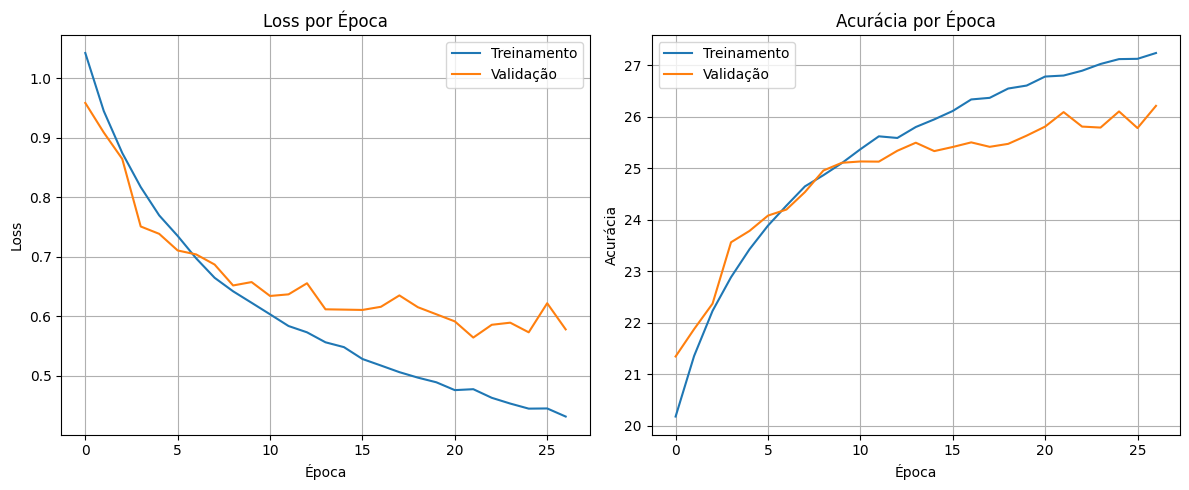

In [73]:
plotTrainVal(train_losses, val_losses, train_acc, val_acc)

In [63]:
targets, predictions = makePredictions(net, test_loader)

get_scores(targets, predictions)

{'accuracy': 0.821,
 'balanced_accuracy': 0.8210000000000001,
 'precision': 0.820982136221598,
 'recall': 0.821,
 'f1_score': 0.8199234401769443}

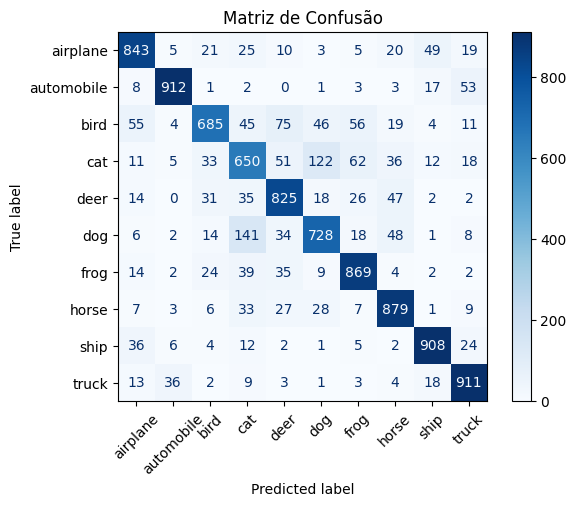

In [ ]:
cm = confusion_matrix(targets, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Experiment 2: Batch Normalization

Neste experimento foram realizadas operações de batch normalizations após cada convolução.

| Métrica              | Valor     |
|----------------------|-----------|
| Acurácia             | 0.8655    |
| Acurácia Balanceada  | 0.8655    |
| Precisão             | 0.8687    |
| Revocação (Recall)   | 0.8655    |
| F1-Score             | 0.8646    |

- Treinou por 26 épocas até o early stopping
- 6 minutos e 10 segundos -> média de 14,2 s por época

Comparação com o experimento anterior:
- 15% mais rápido que o treinamento anterior. 
- Aumento de 4,4% na acurácia.
- O treinamento ocorreu de forma mais suave, com menos variação no loss e na acurácia.

In [74]:
# Hiperparâmetros
arch=((1, 64),
      (2, 128),
      (2, 256))

batch_size = 32
learning_rate = 1e-3
dropout = 0
batch_norm = True
num_epochs=40
patience=5

In [76]:
#instancia a rede
net = CNN(arch=((1, 64), (2, 128), (2, 256)), batch_norm=batch_norm)
net.to(device)

#função de perda (loss)
criterion = nn.CrossEntropyLoss()

#otimizador
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [77]:
net, train_losses, val_losses, train_acc, val_acc = train_model(net, 
                                                                train_loader, 
                                                                val_loader, 
                                                                criterion, 
                                                                optimizer, 
                                                                device, 
                                                                num_epochs=num_epochs, 
                                                                patience=patience)

# salvar o modelo treinado
torch.save(net.state_dict(), "best_model_exp2.pth")

  0%|          | 0/40 [00:10<?, ?it/s]

Epoch 1/40, Step 1000/1250, Loss: 1.2488


  2%|▎         | 1/40 [00:15<10:00, 15.39s/it]

Epoch 1 completed. Train Loss: 1.5265 | Val Loss: 1.2727


  2%|▎         | 1/40 [00:25<10:00, 15.39s/it]

Epoch 2/40, Step 1000/1250, Loss: 1.3758


  5%|▌         | 2/40 [00:30<09:42, 15.33s/it]

Epoch 2 completed. Train Loss: 1.1403 | Val Loss: 1.1189


  5%|▌         | 2/40 [00:40<09:42, 15.33s/it]

Epoch 3/40, Step 1000/1250, Loss: 0.6348


  8%|▊         | 3/40 [00:45<09:20, 15.15s/it]

Epoch 3 completed. Train Loss: 0.9570 | Val Loss: 0.8680


  8%|▊         | 3/40 [00:55<09:20, 15.15s/it]

Epoch 4/40, Step 1000/1250, Loss: 0.6200


 10%|█         | 4/40 [01:00<08:56, 14.90s/it]

Epoch 4 completed. Train Loss: 0.8257 | Val Loss: 0.7605


 10%|█         | 4/40 [01:09<08:56, 14.90s/it]

Epoch 5/40, Step 1000/1250, Loss: 0.7829


 12%|█▎        | 5/40 [01:14<08:33, 14.66s/it]

Epoch 5 completed. Train Loss: 0.7413 | Val Loss: 0.7021


 12%|█▎        | 5/40 [01:24<08:33, 14.66s/it]

Epoch 6/40, Step 1000/1250, Loss: 0.8007


 15%|█▌        | 6/40 [01:28<08:11, 14.47s/it]

Epoch 6 completed. Train Loss: 0.6674 | Val Loss: 0.6752


 15%|█▌        | 6/40 [01:38<08:11, 14.47s/it]

Epoch 7/40, Step 1000/1250, Loss: 0.5009


 18%|█▊        | 7/40 [01:42<07:54, 14.38s/it]

Epoch 7 completed. Train Loss: 0.6126 | Val Loss: 0.5505


 18%|█▊        | 7/40 [01:52<07:54, 14.38s/it]

Epoch 8/40, Step 1000/1250, Loss: 0.5401


 20%|██        | 8/40 [01:57<07:39, 14.37s/it]

Epoch 8 completed. Train Loss: 0.5698 | Val Loss: 0.6604


 20%|██        | 8/40 [02:06<07:39, 14.37s/it]

Epoch 9/40, Step 1000/1250, Loss: 0.7846


 22%|██▎       | 9/40 [02:11<07:23, 14.29s/it]

Epoch 9 completed. Train Loss: 0.5274 | Val Loss: 0.5263


 22%|██▎       | 9/40 [02:20<07:23, 14.29s/it]

Epoch 10/40, Step 1000/1250, Loss: 0.5242


 25%|██▌       | 10/40 [02:25<07:07, 14.26s/it]

Epoch 10 completed. Train Loss: 0.4877 | Val Loss: 0.4986


 25%|██▌       | 10/40 [02:34<07:07, 14.26s/it]

Epoch 11/40, Step 1000/1250, Loss: 0.2354


 28%|██▊       | 11/40 [02:39<06:50, 14.14s/it]

Epoch 11 completed. Train Loss: 0.4535 | Val Loss: 0.4891


 28%|██▊       | 11/40 [02:48<06:50, 14.14s/it]

Epoch 12/40, Step 1000/1250, Loss: 0.4645


 30%|███       | 12/40 [02:53<06:34, 14.10s/it]

Epoch 12 completed. Train Loss: 0.4300 | Val Loss: 0.4893


 30%|███       | 12/40 [03:02<06:34, 14.10s/it]

Epoch 13/40, Step 1000/1250, Loss: 0.5127


 32%|███▎      | 13/40 [03:07<06:19, 14.06s/it]

Epoch 13 completed. Train Loss: 0.4017 | Val Loss: 0.4692


 32%|███▎      | 13/40 [03:16<06:19, 14.06s/it]

Epoch 14/40, Step 1000/1250, Loss: 0.5790


 35%|███▌      | 14/40 [03:21<06:05, 14.08s/it]

Epoch 14 completed. Train Loss: 0.3764 | Val Loss: 0.4503


 35%|███▌      | 14/40 [03:30<06:05, 14.08s/it]

Epoch 15/40, Step 1000/1250, Loss: 0.3454


 38%|███▊      | 15/40 [03:35<05:51, 14.04s/it]

Epoch 15 completed. Train Loss: 0.3506 | Val Loss: 0.4819


 38%|███▊      | 15/40 [03:44<05:51, 14.04s/it]

Epoch 16/40, Step 1000/1250, Loss: 0.6235


 40%|████      | 16/40 [03:49<05:37, 14.07s/it]

Epoch 16 completed. Train Loss: 0.3369 | Val Loss: 0.4296


 40%|████      | 16/40 [03:58<05:37, 14.07s/it]

Epoch 17/40, Step 1000/1250, Loss: 0.1570


 42%|████▎     | 17/40 [04:03<05:23, 14.05s/it]

Epoch 17 completed. Train Loss: 0.3103 | Val Loss: 0.4334


 42%|████▎     | 17/40 [04:13<05:23, 14.05s/it]

Epoch 18/40, Step 1000/1250, Loss: 0.1466


 45%|████▌     | 18/40 [04:17<05:09, 14.08s/it]

Epoch 18 completed. Train Loss: 0.3006 | Val Loss: 0.4470


 45%|████▌     | 18/40 [04:27<05:09, 14.08s/it]

Epoch 19/40, Step 1000/1250, Loss: 0.0440


 48%|████▊     | 19/40 [04:31<04:56, 14.12s/it]

Epoch 19 completed. Train Loss: 0.2757 | Val Loss: 0.4608


 48%|████▊     | 19/40 [04:41<04:56, 14.12s/it]

Epoch 20/40, Step 1000/1250, Loss: 0.2277


 50%|█████     | 20/40 [04:46<04:44, 14.21s/it]

Epoch 20 completed. Train Loss: 0.2674 | Val Loss: 0.4272


 50%|█████     | 20/40 [04:56<04:44, 14.21s/it]

Epoch 21/40, Step 1000/1250, Loss: 0.1269


 52%|█████▎    | 21/40 [05:00<04:29, 14.20s/it]

Epoch 21 completed. Train Loss: 0.2545 | Val Loss: 0.4107


 52%|█████▎    | 21/40 [05:10<04:29, 14.20s/it]

Epoch 22/40, Step 1000/1250, Loss: 0.0746


 55%|█████▌    | 22/40 [05:14<04:15, 14.18s/it]

Epoch 22 completed. Train Loss: 0.2456 | Val Loss: 0.4246


 55%|█████▌    | 22/40 [05:24<04:15, 14.18s/it]

Epoch 23/40, Step 1000/1250, Loss: 0.4226


 57%|█████▊    | 23/40 [05:28<04:00, 14.12s/it]

Epoch 23 completed. Train Loss: 0.2283 | Val Loss: 0.4128


 57%|█████▊    | 23/40 [05:38<04:00, 14.12s/it]

Epoch 24/40, Step 1000/1250, Loss: 0.2660


 60%|██████    | 24/40 [05:42<03:45, 14.11s/it]

Epoch 24 completed. Train Loss: 0.2156 | Val Loss: 0.4602


 60%|██████    | 24/40 [05:52<03:45, 14.11s/it]

Epoch 25/40, Step 1000/1250, Loss: 0.1099


 62%|██████▎   | 25/40 [05:56<03:31, 14.08s/it]

Epoch 25 completed. Train Loss: 0.2116 | Val Loss: 0.4319


 62%|██████▎   | 25/40 [06:06<03:31, 14.08s/it]

Epoch 26/40, Step 1000/1250, Loss: 0.1824


 62%|██████▎   | 25/40 [06:10<03:42, 14.83s/it]

Epoch 26 completed. Train Loss: 0.1959 | Val Loss: 0.4583
Early stopping at epoch 26


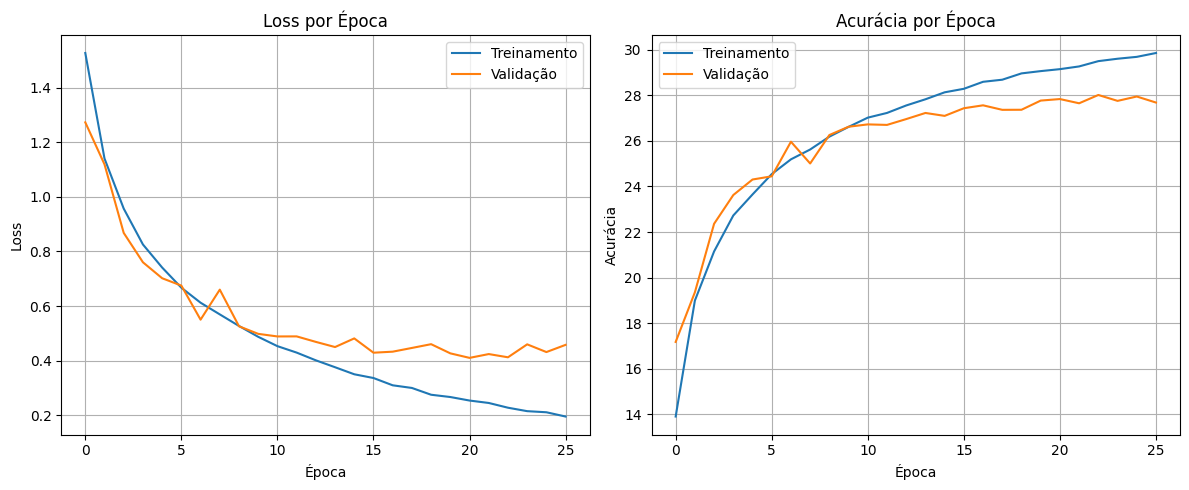

In [78]:
plotTrainVal(train_losses, val_losses, train_acc, val_acc)

In [79]:
targets, predictions = makePredictions(net, test_loader)

get_scores(targets, predictions)

{'accuracy': 0.8655,
 'balanced_accuracy': 0.8654999999999999,
 'precision': 0.8686685969175907,
 'recall': 0.8655,
 'f1_score': 0.8645830146058364}

## Grad-cam

In [65]:
def show_cam_on_image(img):
    img = img.cpu()
    scores = net(img.unsqueeze(0))  # adiciona batch dimension

    # Extrair heatmap para a classe predita
    class_id = scores.argmax().item()
    activation_map = cam_extractor(class_id, scores)[0].cpu()

    img = img.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    heatmap = activation_map.squeeze().numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    resized_map = cv2.resize(heatmap, dsize=(32, 32), interpolation=cv2.INTER_LINEAR)

    resized_map = plt.cm.jet(resized_map)[..., :3]
    cam = resized_map * 0.5 + img * 0.5
    plt.imshow(cam)
    plt.axis('off')

In [66]:
net = CNN(arch=((1, 64), (2, 128), (2, 256)))
net.cpu()

net.load_state_dict(torch.load("best_model_exp1.pth", weights_only=True))

target_layer = net.feature_extractor[-1][0]  # <- último conv do último bloco
# GradCAM com essa camada
cam_extractor = GradCAM(net, target_layer=target_layer)

In [67]:
classes = test_dataset.classes

cat_imgs = []
# Itera sobre o dataset até encontrar uma imagem para cada uma das 10 classes
for img, label in test_dataset:
    class_name = classes[label]
    if class_name == 'cat':
        cat_imgs.append(img)
    # Para de procurar quando já tiver uma imagem de cada classe
    if len(cat_imgs) == 10:
        break

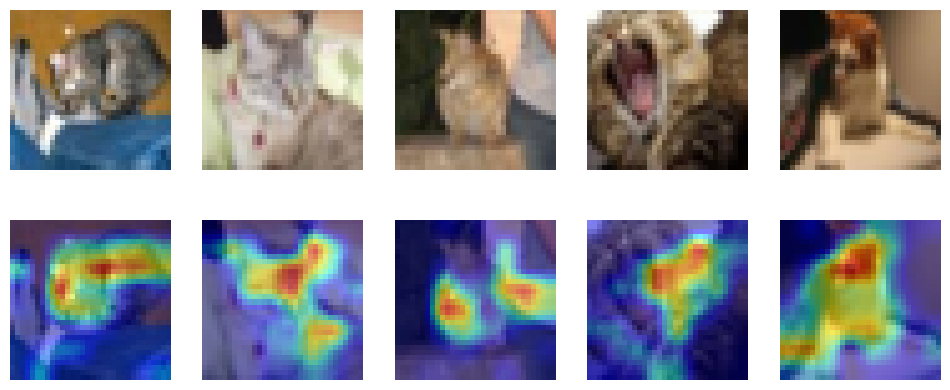

In [68]:
# Criar uma figura para exibir as imagens
fig = plt.figure(figsize=(12, 5))

# Exibe uma imagem para cada classe
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1) # Cria uma grade 2x5 de subplots
    img = cat_imgs[i%5]

    if i > 4:
        show_cam_on_image(img)
    else:
        imshow(img)


plt.show()

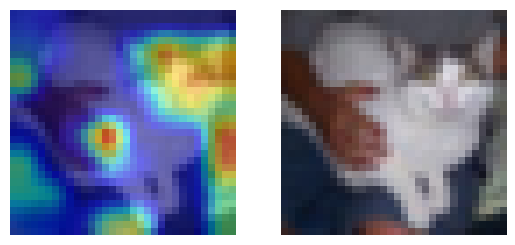

In [71]:
fig = plt.figure()

idx = 7

# Exibe uma imagem para cada classe
ax = fig.add_subplot(1, 2, 1)
show_cam_on_image(cat_imgs[idx])

ax = fig.add_subplot(1, 2, 2)
imshow(cat_imgs[idx])
